# Nearest neighbors
[Index](0-index.ipynb)

Here we compute matrices the matrix of distances between communities, $[d_{ab}]$.

## Imports and global variables

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.gridspec as mgs
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib import animation
plt.rcParams['svg.fonttype'] = 'none'

from IPython.display import HTML
from IPython.display import Image

In [3]:
sys.path.append('../code')
from functions import show_image, geo_dist

In [4]:
resdir = Path('../results/')
if not resdir.is_dir():
    raise ValueError('No results directory!')

In [5]:
resfile = resdir / 'safegraph_analysis.hdf5'
complevel=7
complib='zlib'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    print(f"File {resfile.stem} has {len(store.keys())} entries.")

File safegraph_analysis has 2188 entries.


In [6]:
tfmt = '%Y-%m-%d'

In [7]:
figdir = Path('../figures') / '4-distances'
if not figdir.is_dir():
    figdir.mkdir(parents=True, exist_ok=True)
exts = ['.png', '.svg']

## Functions
We use the [formula](https://en.wikipedia.org/wiki/Geographical_distance) of the Spherical Earth projected to a plane. for the 'Spherical Earth projected to a plane':
\begin{equation}
d(M_1,M_2) = R \sqrt{\Delta \phi^2 + \cos{\bar{\phi}} \Delta \lambda^2},
\end{equation}
where $\phi$ is the latitude, $\lambda$ is the longitude, and $\bar{\phi} = (\phi_1 + \phi_2)/2$. $R = 6, 371.009 \, \mathrm{km}$ is the radius of the Earth.

Here `X` is the longitude and `Y` is the latitude (see this [notebook](06-cross_compare_cssegi.ipynb)).

In [8]:
R_earth = 6.371009e6

## Clusters

### Load clusters

In [9]:
key = "/clustering/clusters"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    clusters = store[key]
# clusters = pd.read_hdf(resfile, key)
N = len(clusters)
print(f"N = {N}")
clusters

N = 1024


,leaves,X,Y,cbg_clusters,population,mobile_count
index,,,,,,
0,746,-65.794825,18.277415,"[720531504003, 720531501044, 720531505001, 720...",390728,8705.198547
1,458,-66.083320,18.131576,"[720572702011, 720572703004, 720572705001, 720...",488287,10942.351090
2,873,-66.079340,18.396328,"[720210307001, 720210310113, 720210316223, 720...",1011530,28389.915254
3,8,-66.344566,18.363775,"[720399559001, 720399556001, 720399557001, 720...",425126,9988.154964
4,641,-66.582628,18.044742,"[721130724005, 721130727011, 721130727012, 721...",354598,12057.116223
...,...,...,...,...,...,...
1019,911,-158.026269,21.423245,"[150030078092, 150030078102, 150030099044, 150...",459209,22780.496368
1020,7,-157.813184,21.329035,"[150090318011, 150099900000, 150030047001, 150...",529047,21868.060533
1021,392,-156.517054,20.867763,"[150090311032, 150090304042, 150090309034, 150...",161290,7878.004843


## Compute distance matrix using Spherical Earth projected to a plane formula

In [10]:
XY = clusters.loc[:, ['X','Y']].astype('float64').to_numpy()

Long, Lat = XY.T * np.pi/180.

LLat1, LLat2 = np.meshgrid(Lat, Lat, indexing='ij')
dLLat = LLat1 - LLat2
LLat_bar = 0.5*(LLat1 + LLat2)

LLong1, LLong2 = np.meshgrid(Long, Long, indexing='ij')
dLLong = LLong1 - LLong2

D = R_earth * np.sqrt(dLLat**2 + np.cos(LLat_bar)*dLLong**2)

In [11]:
df_dist = pd.DataFrame(data=D, index=clusters.index, columns=clusters.index)

key = "/clustering/distances"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    store[key] = df_dist

Compare with [equirectangular projection](https://en.wikipedia.org/wiki/Equirectangular_projection) distances

In [12]:
P = clusters.loc[:, ['Y', 'X']].to_numpy()
PP = np.einsum('ik,jk->ij',P,P)
U = np.ones((N,1))
Delta = PP.diagonal().reshape(-1,1)
Dequi = (U*Delta.T) + (Delta*U.T) - 2*PP
Dequi = R_earth * np.pi/180.* np.sqrt(Dequi)

In [13]:
err = np.linalg.norm(D-Dequi)/np.linalg.norm(D)
print("Equirectangular projection error = {:.1f} %".format(err*100))

Equirectangular projection error = 15.1 %


## Some statistics on the actual separation

In [14]:
key = "/clustering/distances"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    df_dist = store[key]

df_dist

index,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
index,,,,,,,,,,,,,,,,,,,,,
0,0.000000e+00,3.522132e+04,3.353937e+04,6.032823e+04,8.922338e+04,1.020716e+05,1.423116e+05,1.367488e+05,3.191928e+06,3.076757e+06,...,1.056508e+07,1.084609e+07,1.163205e+07,1.178416e+07,1.010751e+07,9.952485e+06,9.930626e+06,9.796315e+06,9.740499e+06,9.656786e+06
1,3.522132e+04,0.000000e+00,2.944231e+04,3.831536e+04,5.498573e+04,7.612572e+04,1.141486e+05,1.041719e+05,3.206031e+06,3.090694e+06,...,1.054908e+07,1.082948e+07,1.161449e+07,1.175815e+07,1.007947e+07,9.924250e+06,9.902359e+06,9.767885e+06,9.711705e+06,9.627974e+06
2,3.353937e+04,2.944231e+04,0.000000e+00,2.895685e+04,6.710617e+04,7.027471e+04,1.109507e+05,1.094806e+05,3.176673e+06,3.061348e+06,...,1.053037e+07,1.081124e+07,1.159690e+07,1.175017e+07,1.007443e+07,9.919505e+06,9.897663e+06,9.763436e+06,9.707797e+06,9.624100e+06
3,6.032823e+04,3.831536e+04,2.895685e+04,0.000000e+00,4.386493e+04,4.177766e+04,8.226182e+04,8.112963e+04,3.178601e+06,3.063137e+06,...,1.050835e+07,1.078883e+07,1.157388e+07,1.172304e+07,1.004655e+07,9.891557e+06,9.869703e+06,9.735421e+06,9.679656e+06,9.595954e+06
4,8.922338e+04,5.498573e+04,6.710617e+04,4.386493e+04,0.000000e+00,4.288828e+04,6.809197e+04,5.042405e+04,3.212721e+06,3.097135e+06,...,1.050948e+07,1.078911e+07,1.157288e+07,1.170787e+07,1.002752e+07,9.872132e+06,9.850216e+06,9.715614e+06,9.659143e+06,9.575399e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,9.952485e+06,9.924250e+06,9.919505e+06,9.891557e+06,9.872132e+06,9.849459e+06,9.809312e+06,9.821268e+06,9.521824e+06,9.507770e+06,...,3.765796e+06,3.699263e+06,3.810609e+06,2.018228e+06,1.732468e+05,0.000000e+00,2.514994e+04,1.734402e+05,3.017573e+05,3.706394e+05
1020,9.930626e+06,9.902359e+06,9.897663e+06,9.869703e+06,9.850216e+06,9.827605e+06,9.787448e+06,9.799353e+06,9.506791e+06,9.492439e+06,...,3.779319e+06,3.714520e+06,3.829800e+06,2.043401e+06,1.983721e+05,2.514994e+04,0.000000e+00,1.483572e+05,2.775173e+05,3.456700e+05
1021,9.796315e+06,9.767885e+06,9.763436e+06,9.735421e+06,9.715614e+06,9.693324e+06,9.653116e+06,9.664762e+06,9.408967e+06,9.392986e+06,...,3.851454e+06,3.797212e+06,3.936568e+06,2.191844e+06,3.466731e+05,1.734402e+05,1.483572e+05,0.000000e+00,1.482724e+05,2.026106e+05


In [15]:
Ns = df_dist.index.to_numpy()
dists = df_dist.to_numpy()
dists_sorted = np.sort(dists, axis=-1)

# median distance of 1st, 2nd, 3rd...etc neighbor
dist_med = np.array([np.median(dists_sorted[:,n]) for n in Ns[1:]])

In [16]:
# parameters
figsize = (6,4.5)
dpi = 300
ms=2
lw=1

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

ax.plot(Ns[1:], dist_med/1.0e3, '-', ms=ms, color='darkblue')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(Ns[1],None)
ax.set_xlabel("kth nearest neighbor", fontsize="medium")
ax.set_ylabel("median distance (km)", fontsize="medium")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

fname = 'median_distance_nearest_neighbors'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/4-distances/median_distance_nearest_neighbors.png
Written file: ../figures/4-distances/median_distance_nearest_neighbors.svg


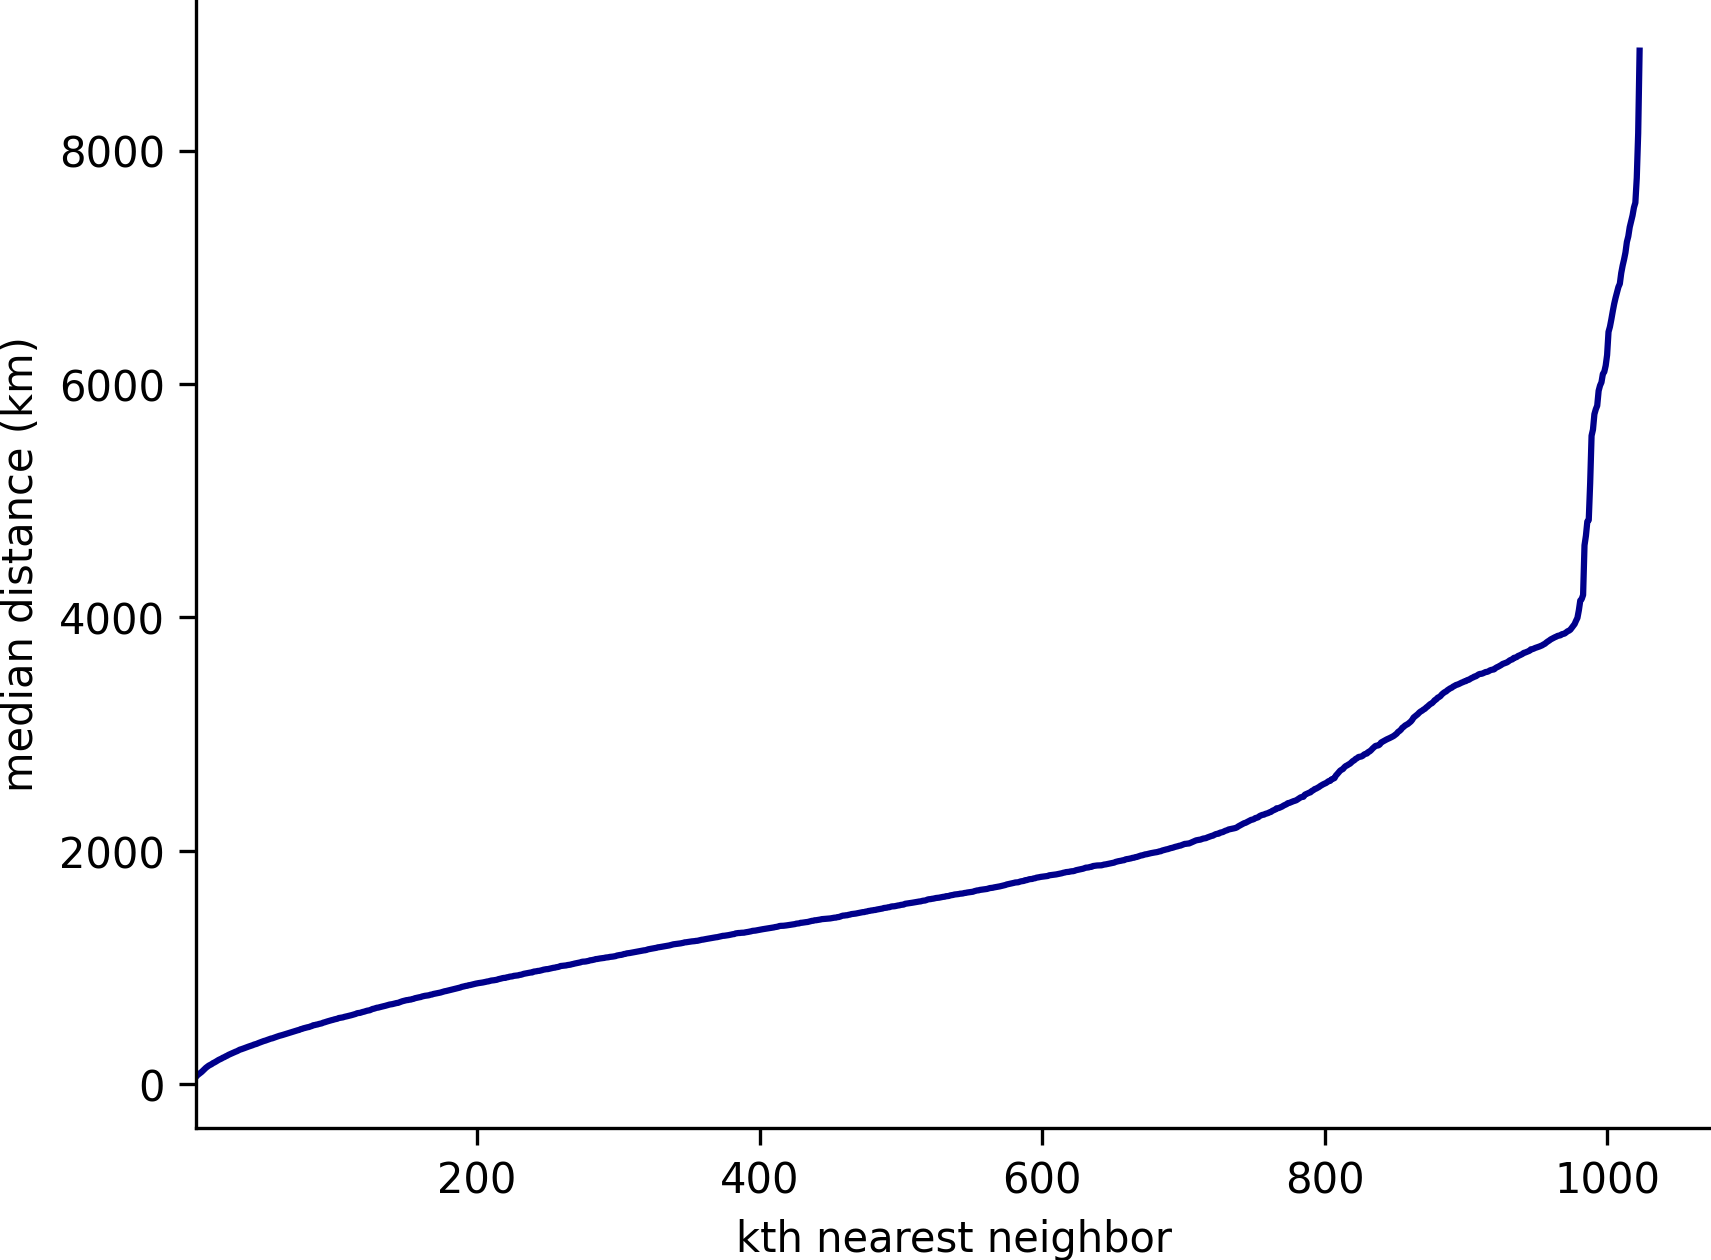

In [17]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)